In [ ]:
#| default_exp ljubljana

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path

import numpy as np
import torch
from diffdrr.data import read
from diffdrr.pose import RigidTransform
from torchio import ScalarImage, Subject

from diffdrrdata.utils import load_file

## Dataset

The `Ljubljana` dataset is a collection of 2D and 3D digital subtraction angiography (DSA) images from 20 patients undergoing neurovascular procedures at the University of Ljubljana. For each patient there is

- One 3D DSA volume (i.e., rotational angiography)
- Two 2D DSA acquisitions (one AP and one LAT)

In total, the dataset comprises 20 3D DSA volumes and 20 2D DSA images.

In [ ]:
#| export
class LjubljanaDataset(torch.utils.data.Dataset):
    """
    A `torch.utils.data.Dataset` that stores the imaging data for subjects
    in the `Ljubljana` dataset.
    """

    def __init__(
        self,
        id_number: int,  # Subject ID in {1, ..., 10}
        preprocess: bool = True,  # Convert X-rays from exponentiated to linear form
    ):
        self.f = load_file("ljubljana.h5")
        self.id_number = id_number
        self.subject, self.anatomical2world = parse_volume(self.f, self.id_number)
        self.preprocess = preprocess

        # Miscellaneous transformation matrices for wrangling SE(3) poses
        self.flip_z = RigidTransform(
            torch.tensor(
                [
                    [0, -1, 0, 0],
                    [1, 0, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1],
                ]
            ).to(torch.float32)
        )
        self.reorient = RigidTransform(self.subject.reorient)

    def __len__(self):
        return 2

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        view = {0: "ap", 1: "lat"}[idx]
        img, world2camera, focal_len, height, width, delx, dely, x0, y0 = parse_proj(
            self.f, self.id_number, view
        )

        if self.preprocess:
            img += 1
            img = img.max().log() - img.log()

        pose = (
            self.reorient.inverse()
            .compose(self.flip_z)
            .compose(world2camera.inverse())
            .compose(self.anatomical2world)
        )

        return img, pose, focal_len, height, width, delx, dely, x0, y0

In [ ]:
#| exporti
def parse_volume(f, subject_id):
    subject = f[f"subject{subject_id:02d}"]

    # Get the volume
    volume = subject["volume/pixels"][:]
    volume = volume[::-1].copy()
    volume = torch.from_numpy(volume).unsqueeze(0)
    volume[volume < 250] = -1000.0

    affine = np.eye((4))
    spacing = subject["volume/spacing"][:]
    affine[0, 0] = spacing[0]
    affine[1, 1] = spacing[1]
    affine[2, 2] = spacing[2]
    affine[:3, 3] = subject["volume/origin"][:]
    affine = torch.from_numpy(affine)

    volume = ScalarImage(tensor=volume, affine=affine)
    fiducials = torch.from_numpy(subject["points"][:]).unsqueeze(0)
    subject = read(
        volume=volume,
        labelmap=None,
        bone_attenuation_multiplier=1.0,
        fiducials=fiducials,
        orientation="AP",
    )
    # Move the Subject's isocenter to the origin in world coordinates
    isocenter = volume.get_center()
    anatomical2world = RigidTransform(
        torch.tensor(
            [
                [1.0, 0.0, 0.0, -isocenter[0]],
                [0.0, 1.0, 0.0, -isocenter[1]],
                [0.0, 0.0, 1.0, -isocenter[2]],
                [0.0, 0.0, 0.0, 1.0],
            ],
            dtype=torch.float32,
        )
    )

    return subject, anatomical2world

In [ ]:
#| exporti
from diffdrr.utils import parse_intrinsic_matrix


def parse_proj(f, subject_id, view):
    proj = f[f"subject{subject_id:02d}/proj-{view}"]

    img = torch.from_numpy(proj["pixels"][:]).unsqueeze(0).unsqueeze(0)
    num_rows, num_cols = proj["pixels"].shape

    extrinsic = torch.from_numpy(proj["extrinsic"][:])
    world2camera = RigidTransform(extrinsic)

    intrinsic = torch.from_numpy(proj["intrinsic"][:])
    proj_col_spacing = float(proj["col-spacing"][()])
    proj_row_spacing = float(proj["row-spacing"][()])
    focal_len, x0, y0 = parse_intrinsic_matrix(
        intrinsic,
        num_rows,
        num_cols,
        proj_row_spacing,
        proj_col_spacing,
    )

    return (
        img,
        world2camera,
        focal_len,
        int(num_rows),
        int(num_cols),
        proj_row_spacing,
        proj_col_spacing,
        x0,
        y0,
    )

In [ ]:
#| export
from torchvision.transforms import Compose, Lambda, Normalize, Resize


class Transforms:
    def __init__(self, height: int, width: int, eps: float = 1e-6):
        """Standardize, resize, and normalize X-rays and DRRs before inputting to a deep learning model."""
        self.transforms = Compose(
            [
                Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + eps)),
                Resize((height, width), antialias=True),
                Normalize(mean=0.0774, std=0.0569),
            ]
        )

    def __call__(self, x):
        return self.transforms(x)

In [ ]:
#| code-fold: true
#| eval: false
from tqdm import tqdm

mean, vars = [], []
for idx in tqdm(range(1, 11), ncols=50):
    specimen = LjubljanaDataset(idx)
    for img, _, _, _, _, _, _, _, _ in specimen:
        img = (img - img.min()) / (img.max() - img.min())
        mean.append(img.mean())
        vars.append(img.var())

print("Pixel mean :", sum(mean) / len(mean))
print("Pixel std dev :", (sum(vars) / len(vars)).sqrt())

  0%|                      | 0/10 [00:00<?, ?it/s]

## Basic functionalities

In the `Ljubljana` dataset, 3D fidicial markers were manually annotated along the centerline of many vessels in the neurovasculature. These can be projected into 2D using projective geometry.

For every DSA acquisition in the `Ljubljana` dataset, we visualize

- The ground truth image
- A DRR rendered from the ground truth pose
- An overlay of projected fiducial markers onto the DRR
- The difference between the ground truth image and the DRR
- The difference between the DRR and the ground truth image

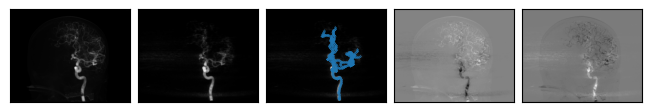

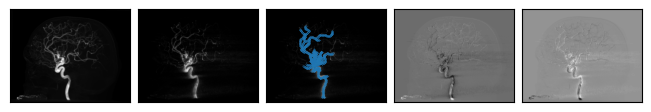

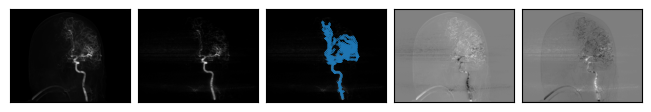

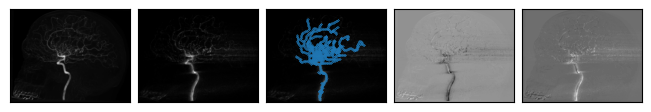

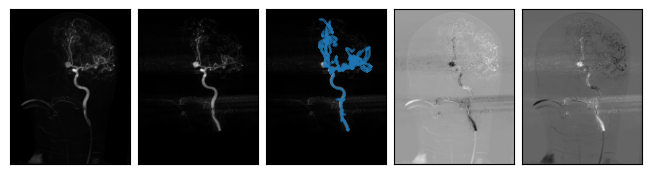

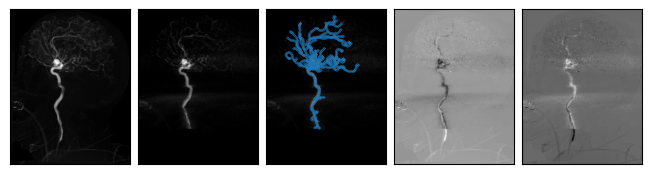

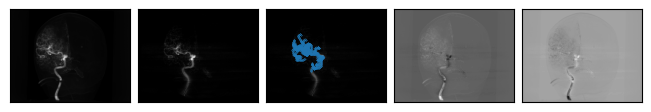

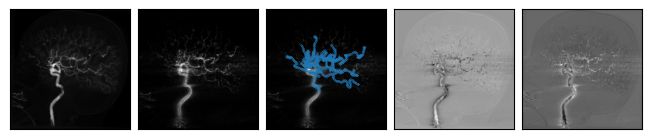

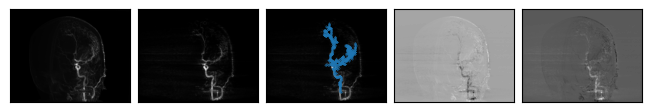

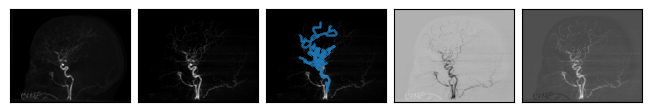

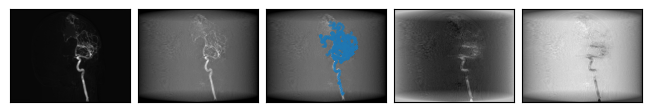

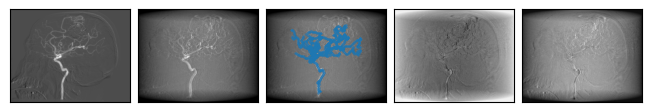

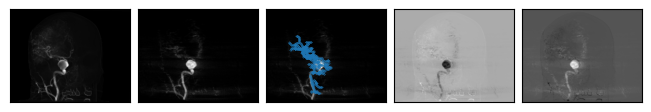

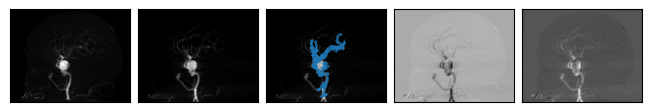

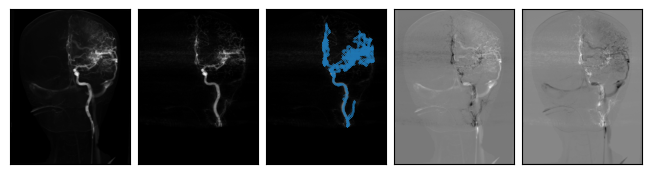

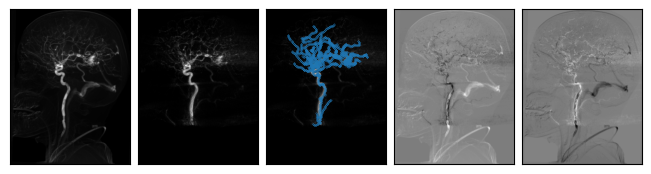

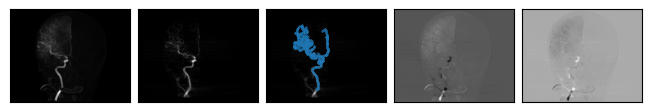

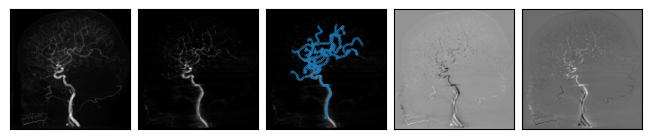

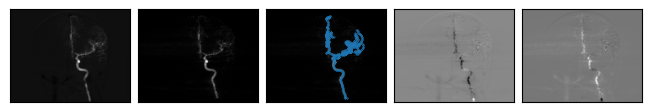

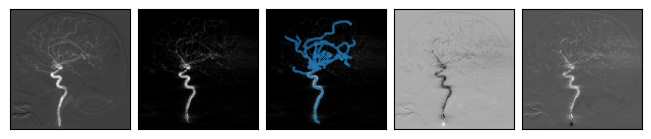

In [ ]:
#| code-fold: true
#| eval: false
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from diffdrr.pose import RigidTransform
from diffdrr.visualization import plot_drr
from tqdm import tqdm


subsample = 8

for id_number in range(1, 11):
    ljubljana = LjubljanaDataset(id_number)

    for gt, pose, focal_len, height, width, delx, dely, x0, y0 in ljubljana:
        height = height // subsample
        width = width // subsample
        delx = delx * subsample
        dely = dely * subsample
        transforms = Transforms(height, width)

        drr = DRR(
            ljubljana.subject,
            focal_len,
            height,
            delx,
            width,
            dely,
            x0,
            y0,
            renderer="trilinear",
        )

        img = drr(pose)
        gt, img = transforms(gt), transforms(img)
        x = drr.perspective_projection(pose, ljubljana.subject.fiducials)

        fig, axs = plt.subplots(ncols=5, constrained_layout=True)
        axs = plot_drr(torch.concat([gt, img, img, gt - img, img - gt]), ticks=False, axs=axs)
        axs[2].scatter(x[0, ..., 0], x[0, ..., 1], s=0.05)
        plt.show()

## Citations

**If you use the `Ljubljana` dataset in your work, please cite the author's original publication:**

```
@article{pernus20133d,
  title={3D-2D registration of cerebral angiograms: A method and evaluation on clinical images},
  author={Mitrović, Uros˘ and S˘piclin, Z˘iga and Likar, Bos˘tjan and Pernus˘, Franjo},
  journal={IEEE transactions on medical imaging},
  volume={32},
  number={8},
  pages={1550--1563},
  year={2013},
  publisher={IEEE}
}
```

**If you find `DiffDRR` or `DiffDRR-Datasets` useful for your work, please cite our paper:**

```
@inproceedings{gopalakrishnan2022fast,
  title={Fast auto-differentiable digitally reconstructed radiographs for solving inverse problems in intraoperative imaging},
  author={Gopalakrishnan, Vivek and Golland, Polina},
  booktitle={Workshop on Clinical Image-Based Procedures},
  pages={1--11},
  year={2022},
  organization={Springer}
}
```

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()